Задачу look-a-like будем решать на примере поиска сегмента клиентов, склонных к оттоку из некого банка. Датасет содержит ретро-данные о клиентах, оттекших из банка - целевой сегмент. Аналогично - имеются данные о тех, кто не оттек. Необходимо для любого другого клиента из тестовой выборки определить вероятность (склонность к оттоку).

**Задача**: построить модель классификации с предельно большим значением ROC-AUC

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling


# Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

# Установка настроек для отображения всех колонок и строк при печати
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# заранее установим в константу random_state
random_state = 47

sns.set(style="whitegrid")

In [2]:
churn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OTUS/Churn_Modelling.csv')
print(churn.shape)
churn.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Признаки**

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**

- Exited — факт ухода клиента

Сразу исключим ненужные столбцы, чтобы модели не переобучались под пользователей:

In [3]:
churn = churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Кодирование

В данных есть категориальные и количественные признаки. Без кодировщика не обойтись.

Далее будем обучать следующие модели: логистическую регрессию, SVM, решающее дерево, случайный лес и бустинг. Ко всему датасету применим One-Hot и будем использовать для всех моделей.

In [4]:
# One-Hot для логрега (для зелени тоже подходит)
churn = pd.get_dummies(churn, drop_first=True)
print(churn.shape)
churn.head()

(10000, 12)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


## Семплирование

Делим на выборки:

In [5]:
features = churn.drop(['Exited'], axis=1)
target = churn['Exited']

In [6]:
# мощность классов
target.value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [7]:
target.mean()

0.2037

In [8]:
# отделяем 20% - пятую часть всего - на тестовую выборку
X_train_valid, X_test, y_train_valid, y_test = train_test_split(features, target,
                                                                            test_size=0.2,
                                                                            random_state=random_state)
# отделяем 25% - четвертую часть трейн+валид - на валидирующую выборку
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid,
                                                                              test_size=0.25,
                                                                              random_state=random_state)

s1 = y_train.size
s2 = y_valid.size
s3 = y_test.size
print('Разбиение на выборки train:valid:test в соотношении '
      + str(round(s1/s3)) + ':' + str(round(s2/s3)) + ':' + str(round(s3/s3)))

Разбиение на выборки train:valid:test в соотношении 3:1:1


In [9]:
targets = [y_train, y_train_valid, y_valid, y_test]
names = ['train:', 'train+valid:', 'valid:', 'test:']
print('Баланс классов на разбиениях:\n')
i = 0
for target in targets:
    pc = target.mean()
    print(names[i], pc)
    i += 1

Баланс классов на разбиениях:

train: 0.20116666666666666
train+valid: 0.20175
valid: 0.2035
test: 0.2115


## Масштабирование

Среди моделей, выбранных для исследования, есть линейные. Качество линейных алгоритмов зависит от масштаба данных. Признаки должны быть нормализованы. Если масштаб одного признака сильно превосходит масштаб других, то качество может резко упасть. Для нормализации используем стандартизацию признаков: возьмем набор значений признака на всех объектах, вычислим их среднее значение и стандартное отклонение. После этого из всех значений признака вычтем среднее, и затем полученную разность поделим на стандартное отклонение. Сделает это StandardScaler()...

In [10]:
# Выделяем количественные признаки для стандартизации
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

# Параметры стандартизации получим на трейне
scaler = StandardScaler()
scaler.fit(X_train[numeric])

# Преобразуем все выборки на основе параметров, полученных выше
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

X_train_valid[numeric] = scaler.fit_transform(X_train_valid[numeric])

Значения по выбранным количественным признакам теперь выглядят немного неадекватно, зато с нулевым средним и среднеквадратичным, равным 1.

# Вспомогательные функции

In [11]:
# Функция для оценки модели
def calc_metrics(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    # Обучение
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_train)

    # Валидация
    y_valid_pred = model.predict(X_valid)
    y_valid_proba = model.predict_proba(X_valid)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_valid)

    # Тестирование
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    train_metrics = {
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'roc_auc': roc_auc_score(y_train, y_train_proba)
    }

    valid_metrics = {
        'precision': precision_score(y_valid, y_valid_pred),
        'recall': recall_score(y_valid, y_valid_pred),
        'f1': f1_score(y_valid, y_valid_pred),
        'roc_auc': roc_auc_score(y_valid, y_valid_proba)
    }

    test_metrics = {
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba)
    }

    return train_metrics, valid_metrics, test_metrics

def print_metrics(model, X_train, y_train, X_valid, y_valid, X_test, y_test):
    res = calc_metrics(model, X_train, y_train, X_valid, y_valid, X_test, y_test)
    metrics = pd.DataFrame(res, index=['train', 'valid', 'test'])
    return metrics

# CatBoostClassifier

https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier

In [12]:
!pip install catboost optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.8 MB/s eta 0:00:00


In [13]:
from catboost import CatBoostClassifier
import optuna

In [14]:
def objective(trial):
    param = {
        "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.9),
        "max_depth": trial.suggest_int("max_depth", 2, 7),
        "l2_leaf_reg":trial.suggest_float('l2_leaf_reg', 0.01, 2),
        "subsample": trial.suggest_float('subsample', 0.01, 1),
        "random_strength": trial.suggest_float('random_strength', 1, 200),
        "min_data_in_leaf":trial.suggest_float('min_data_in_leaf', 1, 500)
    }

    cat = CatBoostClassifier(
        logging_level="Silent",
        eval_metric="AUC",
        grow_policy="Lossguide",
        random_seed=42,
        **param)
    cat.fit(X_train, y_train,
            eval_set=(X_valid, y_valid),
            verbose=False,
            early_stopping_rounds=10
           )

    preds = cat.predict_proba(X_valid)[:,1]
    auc = roc_auc_score(y_valid, preds)

    return auc

In [15]:
study = optuna.create_study(direction="maximize", study_name='CatBoostClassifier')
study.optimize(objective, n_trials=20)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-13 17:58:20,930] A new study created in memory with name: CatBoostClassifier
[I 2024-06-13 17:58:21,352] Trial 0 finished with value: 0.8425197154010713 and parameters: {'learning_rate': 0.7884003454336327, 'max_depth': 4, 'l2_leaf_reg': 1.0011633257459809, 'subsample': 0.6683222505414792, 'random_strength': 103.74264783233119, 'min_data_in_leaf': 415.22705447156926}. Best is trial 0 with value: 0.8425197154010713.
[I 2024-06-13 17:58:21,722] Trial 1 finished with value: 0.8528127511178358 and parameters: {'learning_rate': 0.23750905926792018, 'max_depth': 3, 'l2_leaf_reg': 0.8754382441608605, 'subsample': 0.41498375528759396, 'random_strength': 146.36048163309667, 'min_data_in_leaf': 18.10922118547789}. Best is trial 1 with value: 0.8528127511178358.
[I 2024-06-13 17:58:22,163] Trial 2 finished with value: 0.8182080385470216 and parameters: {'learning_rate': 0.013590704070086921, 'max_depth': 5, 'l2_leaf_reg': 1.3155228540198796, 'subsample': 0.2548804223747458, 'random_str

Number of finished trials: 20
Best trial:
Value: 0.8576696881781627
Params: 
    learning_rate: 0.14278243621975611
    max_depth: 3
    l2_leaf_reg: 0.6619590920835305
    subsample: 0.633896523880525
    random_strength: 72.6977279928545
    min_data_in_leaf: 340.8314994882859


In [16]:
best_cat = CatBoostClassifier(**study.best_params, random_state=random_state)
best_cat.fit(X_train, y_train,
            eval_set=(X_valid, y_valid),
            verbose=False,
             early_stopping_rounds=10
           )

res_cat = print_metrics(best_cat, X_train, y_train, X_valid, y_valid, X_test, y_test)
res_cat

,precision,recall,f1,roc_auc
train,0.807796,0.497929,0.616094,0.888790
valid,0.795833,0.469287,0.590417,0.857495
test,0.749035,0.458629,0.568915,0.860247


# Калибровка

https://scikit-learn.ru/1-16-probability-calibration/

In [17]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

In [18]:
# Платт-калибровка
platt_calibrator = CalibratedClassifierCV(best_cat, method='sigmoid')
platt_calibrator.fit(X_train, y_train)
y_pred_platt = platt_calibrator.predict_proba(X_test)[:, 1]

0:	learn: 0.6292896	total: 1.96ms	remaining: 1.96s
1:	learn: 0.5901984	total: 4.34ms	remaining: 2.17s
2:	learn: 0.5451156	total: 11ms	remaining: 3.65s
3:	learn: 0.5170251	total: 13.4ms	remaining: 3.34s
4:	learn: 0.5016340	total: 20.3ms	remaining: 4.04s
5:	learn: 0.4915416	total: 22.9ms	remaining: 3.79s
6:	learn: 0.4826867	total: 26.9ms	remaining: 3.82s
7:	learn: 0.4777790	total: 30.7ms	remaining: 3.81s
8:	learn: 0.4687640	total: 38ms	remaining: 4.18s
9:	learn: 0.4638079	total: 40.9ms	remaining: 4.04s
10:	learn: 0.4534089	total: 43.4ms	remaining: 3.9s
11:	learn: 0.4514044	total: 46.4ms	remaining: 3.82s
12:	learn: 0.4504890	total: 54.2ms	remaining: 4.11s
13:	learn: 0.4488592	total: 56.6ms	remaining: 3.98s
14:	learn: 0.4469625	total: 60.9ms	remaining: 4s
15:	learn: 0.4427254	total: 63.2ms	remaining: 3.89s
16:	learn: 0.4411184	total: 66.9ms	remaining: 3.87s
17:	learn: 0.4406132	total: 72.1ms	remaining: 3.93s
18:	learn: 0.4389127	total: 78.6ms	remaining: 4.06s
19:	learn: 0.4385949	total: 82

In [19]:
y_pred = best_cat.predict_proba(X_test)[:, 1]

In [20]:
# Изотоническая регрессия
iso_reg = IsotonicRegression(out_of_bounds='clip')
iso_reg.fit(y_pred, y_test)
y_pred_iso = iso_reg.transform(y_pred)

In [21]:
# Оценка калибровки
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
prob_true_platt, prob_pred_platt = calibration_curve(y_test, y_pred_platt, n_bins=10)
prob_true_iso, prob_pred_iso = calibration_curve(y_test, y_pred_iso, n_bins=10)

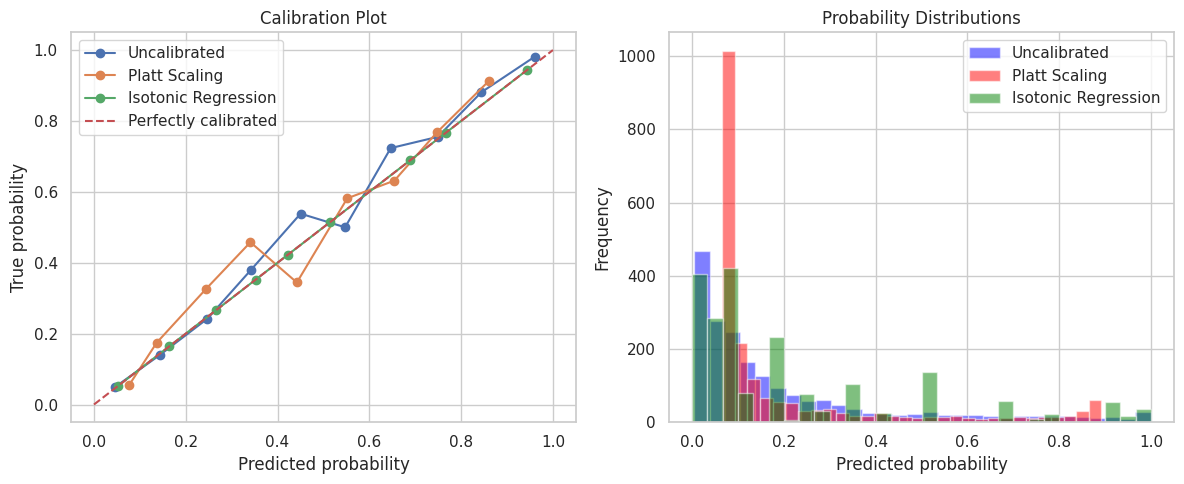

In [22]:
# Визуализация калибровки
plt.figure(figsize=(12, 5))

# Калибровка
plt.subplot(1, 2, 1)
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated')
plt.plot(prob_pred_platt, prob_true_platt, marker='o', label='Platt Scaling')
plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='Isotonic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.legend()
plt.title('Calibration Plot')

# Распределение вероятностей
plt.subplot(1, 2, 2)
plt.hist(y_pred, bins=30, alpha=0.5, label='Uncalibrated', color='blue')
plt.hist(y_pred_platt, bins=30, alpha=0.5, label='Platt Scaling', color='red')
plt.hist(y_pred_iso, bins=30, alpha=0.5, label='Isotonic Regression', color='green')
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Probability Distributions')

plt.tight_layout()
plt.show()